**Project Introduction**

In this project, I will analyze sensor data from machines to predict potential failures. The goal is to leverage various machine learning models to forecast when a machine is likely to fail based on its sensor readings. The models I will employ include Logistic Regression, Random Forest, Gradient Boosting Machines (GBM), and Recurrent Neural Networks (RNN). By comparing the performance of these models using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC, I aim to identify the most effective approach for predictive maintenance. Additionally, I will develop a comprehensive dashboard to visualize the health status of machines and predict maintenance schedules, providing actionable insights to prevent unexpected downtimes and optimize maintenance operations.


**More about the dataset:**
The dataset will be sourced from the UCI Machine Learning Repository:
  Link: https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset
  
The dataset consists of 10,000 data points stored as rows with 14 features in columns:

- **UID:** Unique identifier ranging from 1 to 10,000.
- **Product ID:** Consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants, along with a variant-specific serial number.
- **Air temperature [K]:** Generated using a random walk process, later normalized to a standard deviation of 2 K around 300 K.
- **Process temperature [K]:** Generated using a random walk process, normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- **Rotational speed [rpm]:** Calculated from a power of 2860 W, overlaid with normally distributed noise.
- **Torque [Nm]:** Torque values are normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values.
- **Tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- **Machine failure:** A label that indicates whether the machine has failed at this particular data point for any of the following failure modes.

The machine failure consists of five independent failure modes:

1. **Tool wear failure (TWF):** The tool will be replaced or fail at a randomly selected tool wear time between 200 – 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times and fails 51 times (randomly assigned).
2. **Heat dissipation failure (HDF):** Heat dissipation causes a process failure if the difference between air and process temperature is below 8.6 K and the tool’s rotational speed is below 1380 rpm. This occurs in 115 data points.
3. **Power failure (PWF):** The product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. **Overstrain failure (OSF):** If the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 for M, 13,000 for H), the process fails due to overstrain. This is true for 98 data points.
5. **Random failures (RNF):** Each process has a 0.1% chance to fail regardless of its process parameters. This occurs in only 5 data points, less than expected for 10,000 data points in our dataset.

If at least one of the above failure modes is true, the process fails, and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method which of the failure modes has caused the process to fail.

Precision for Detecting the 1's

Precision should indeed focus on detecting the minority class (1), which represents machine failures. This is crucial because the model is built to identify these failures accurately.

We will start by loading the dataset and displaying the first few rows to understand its structure. Next, we will check for any missing values and handle them appropriately. Finally, we will standardize the data to ensure all features contribute equally to the model's performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip')

# Display the first few rows of the dataset
print(data.head())

# Data Preprocessing
# Handle missing values (if any)
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])

# Add the scaled features back to the dataframe
scaled_data = pd.DataFrame(scaled_features, columns=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
scaled_data['Machine failure'] = data['Machine failure']

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

Now we will do some exploratory (EDA) on this data to understnd the relationship between variables

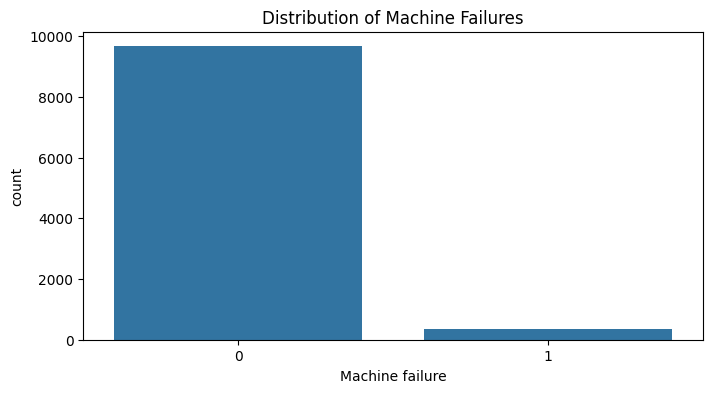

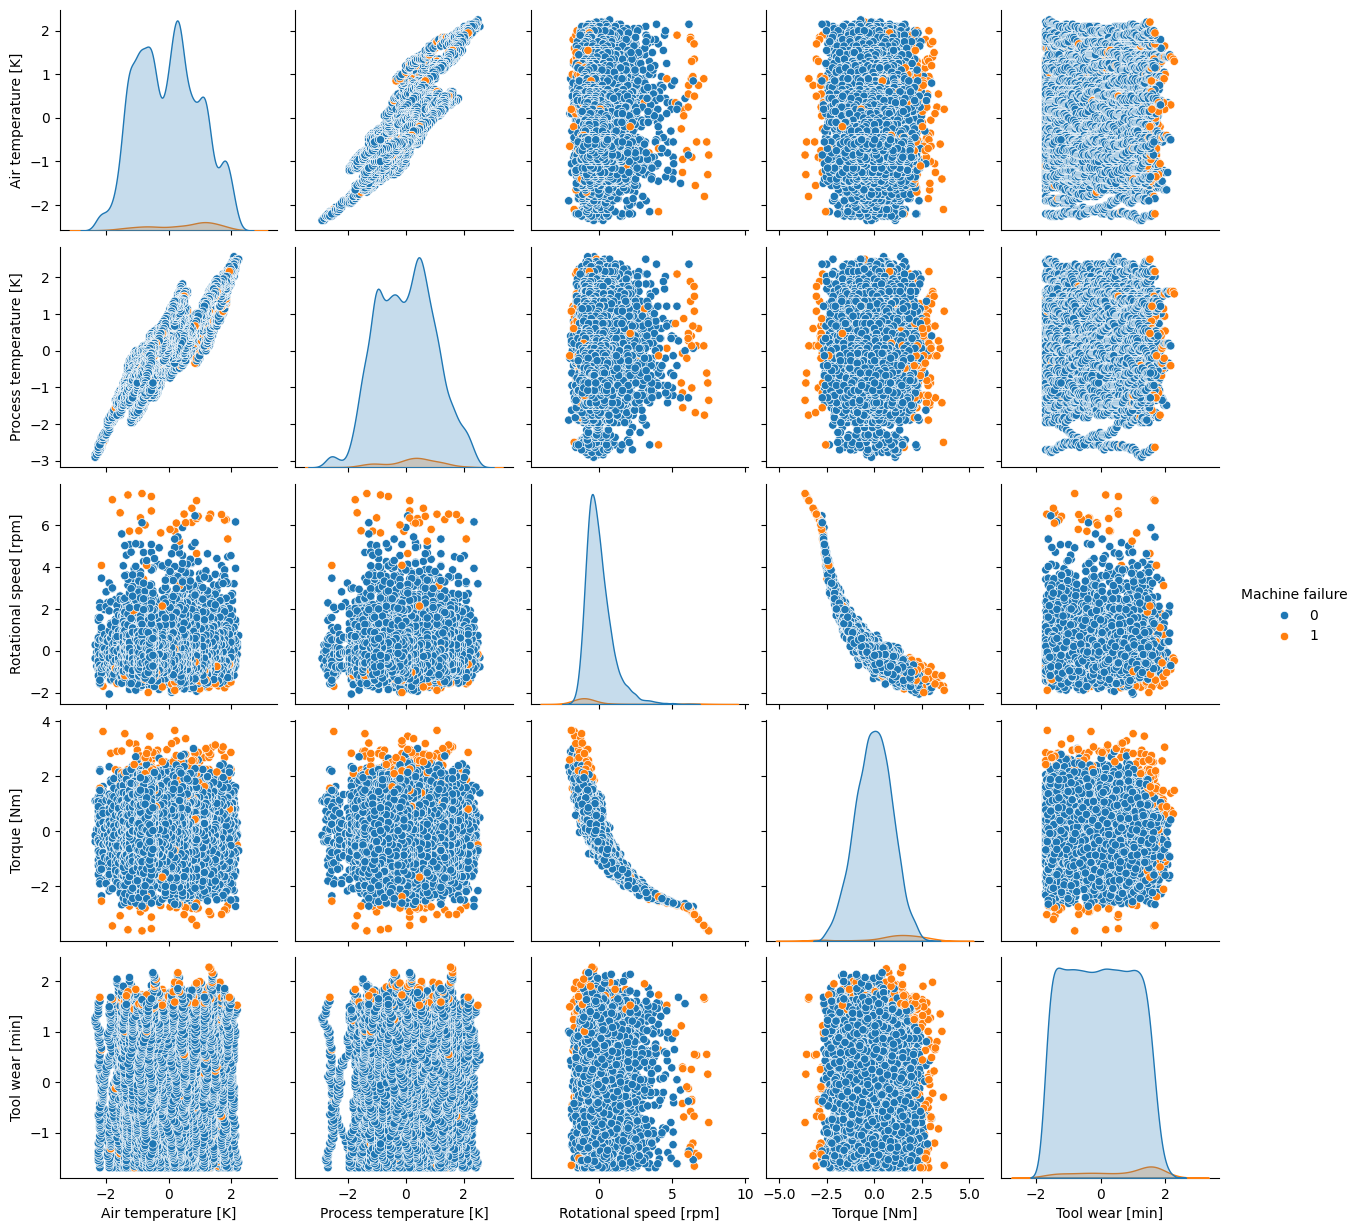

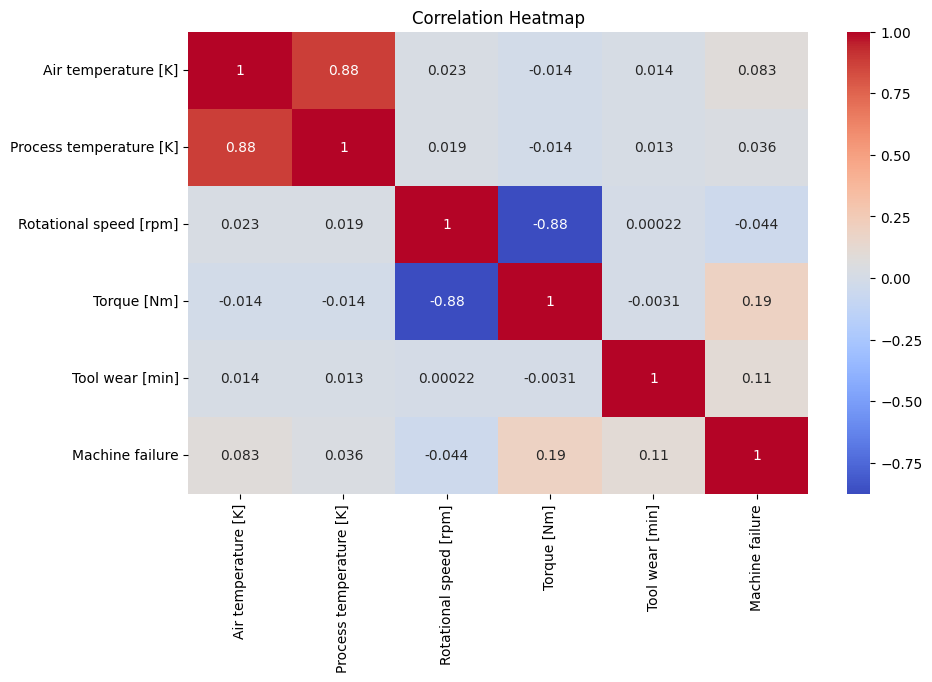

In [3]:
# Visualize the distribution of machine failures
plt.figure(figsize=(8, 4))
sns.countplot(x='Machine failure', data=scaled_data)
plt.title('Distribution of Machine Failures')
plt.show()

# Pair plot to visualize relationships between features
sns.pairplot(scaled_data, hue='Machine failure')
plt.show()

# Heatmap to visualize correlations between features
plt.figure(figsize=(10, 6))
sns.heatmap(scaled_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The count plot shows the distribution of machine failures, indicating how many machines failed versus how many did not.
This visualization helps us understand the class imbalance in the dataset. If there is a significant imbalance (e.g., many more non-failures than failures), it could impact the performance of machine learning models and may require techniques like resampling to address.

The pair plot displays scatter plots for each pair of features, colored by machine failure. This visualization helps us observe the relationships between different features and how they relate to machine failure. We can identify clusters and patterns that might indicate which features are more important for predicting machine failure. For example, certain combinations of features might show clear separation between failure and non-failure cases, such as torque and rotational speed, and rotational speed and air temperature.

The heatmap shows the correlation coefficients between different features.
This visualization helps us understand which features are strongly correlated with each other. High correlation between features might indicate redundancy, while low correlation might indicate independent information.

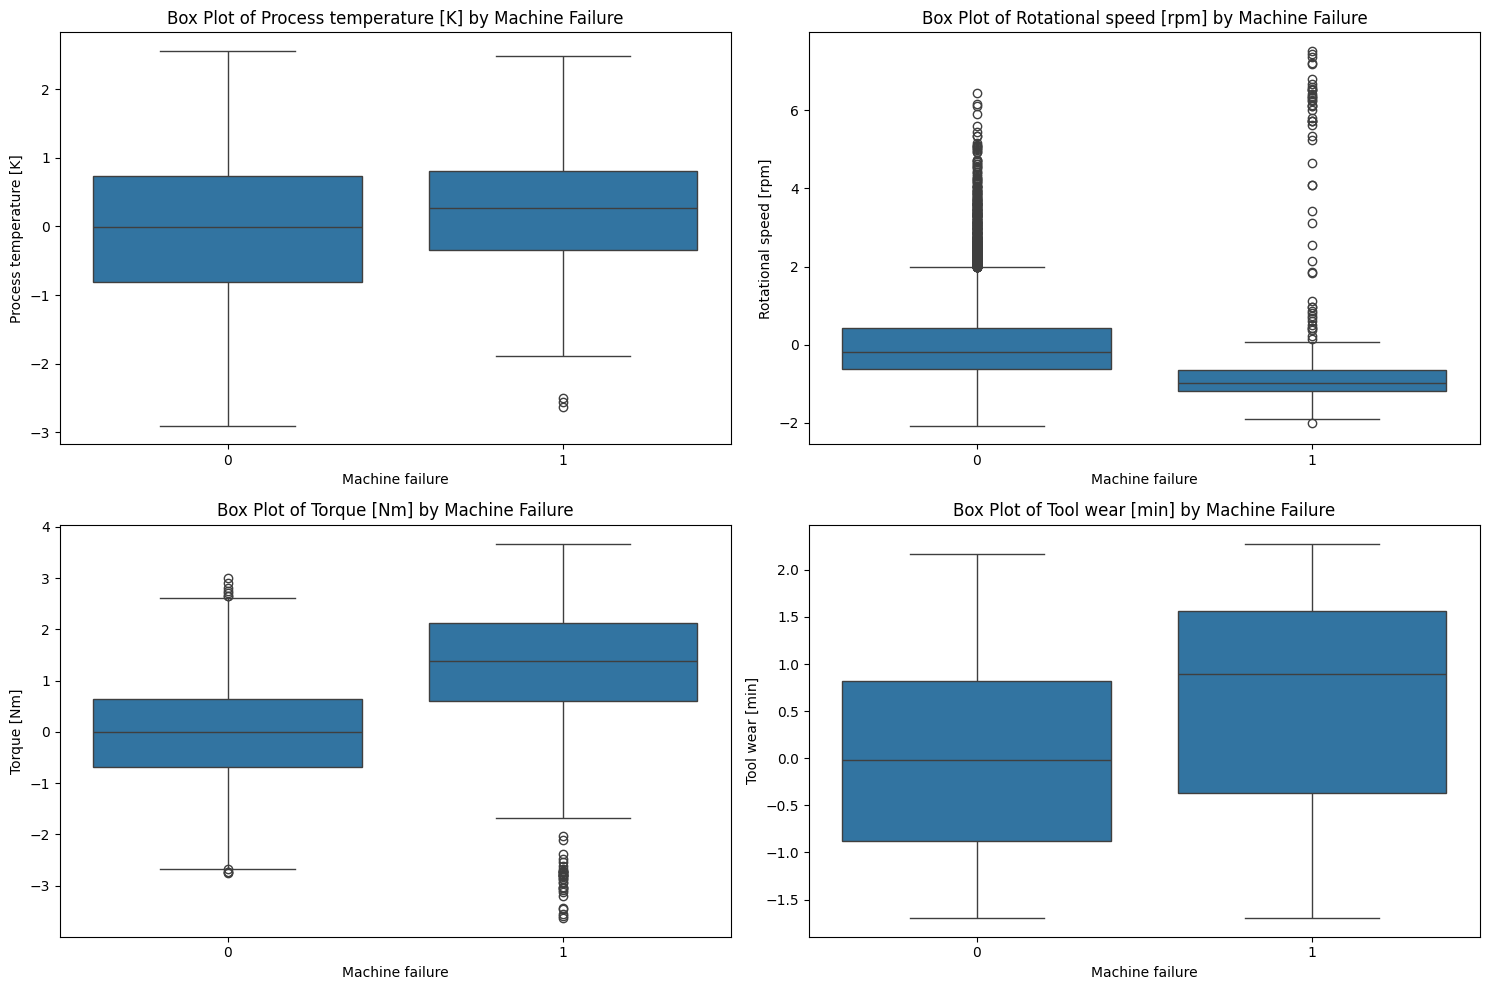

In [4]:
# Box plots to visualize the distribution of each feature with respect to machine failure
plt.figure(figsize=(15, 10))
columns_of_interest = ['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Machine failure', y=column, data=scaled_data)
    plt.title(f'Box Plot of {column} by Machine Failure')
plt.tight_layout()
plt.show()

Process Temperature [K]:

The distribution of process temperature is relatively consistent across both machine failure and non-failure cases.
There are no significant outliers in the process temperature for either failure or non-failure cases, indicating a stable process temperature range.

Rotational Speed [rpm]:

The rotational speed shows a wider range for machines that did not fail compared to those that did.
There are many outliers in the rotational speed for machines that failed and as well as in non-failure cases, suggesting that extreme rotational speeds might be associated with machine failures.

Torque [Nm]:

The torque values for machines that failed are generally lower than those that did not fail.
There are noticeable outliers in the torque values for both failure and non-failure cases, indicating variability in torque measurements.

Tool Wear [min]:

Machines that failed tend to have higher tool wear values compared to those that did not fail.
There are no significant outliers in tool wear for either failure or non-failure cases, indicating a consistent range of tool wear measurements.

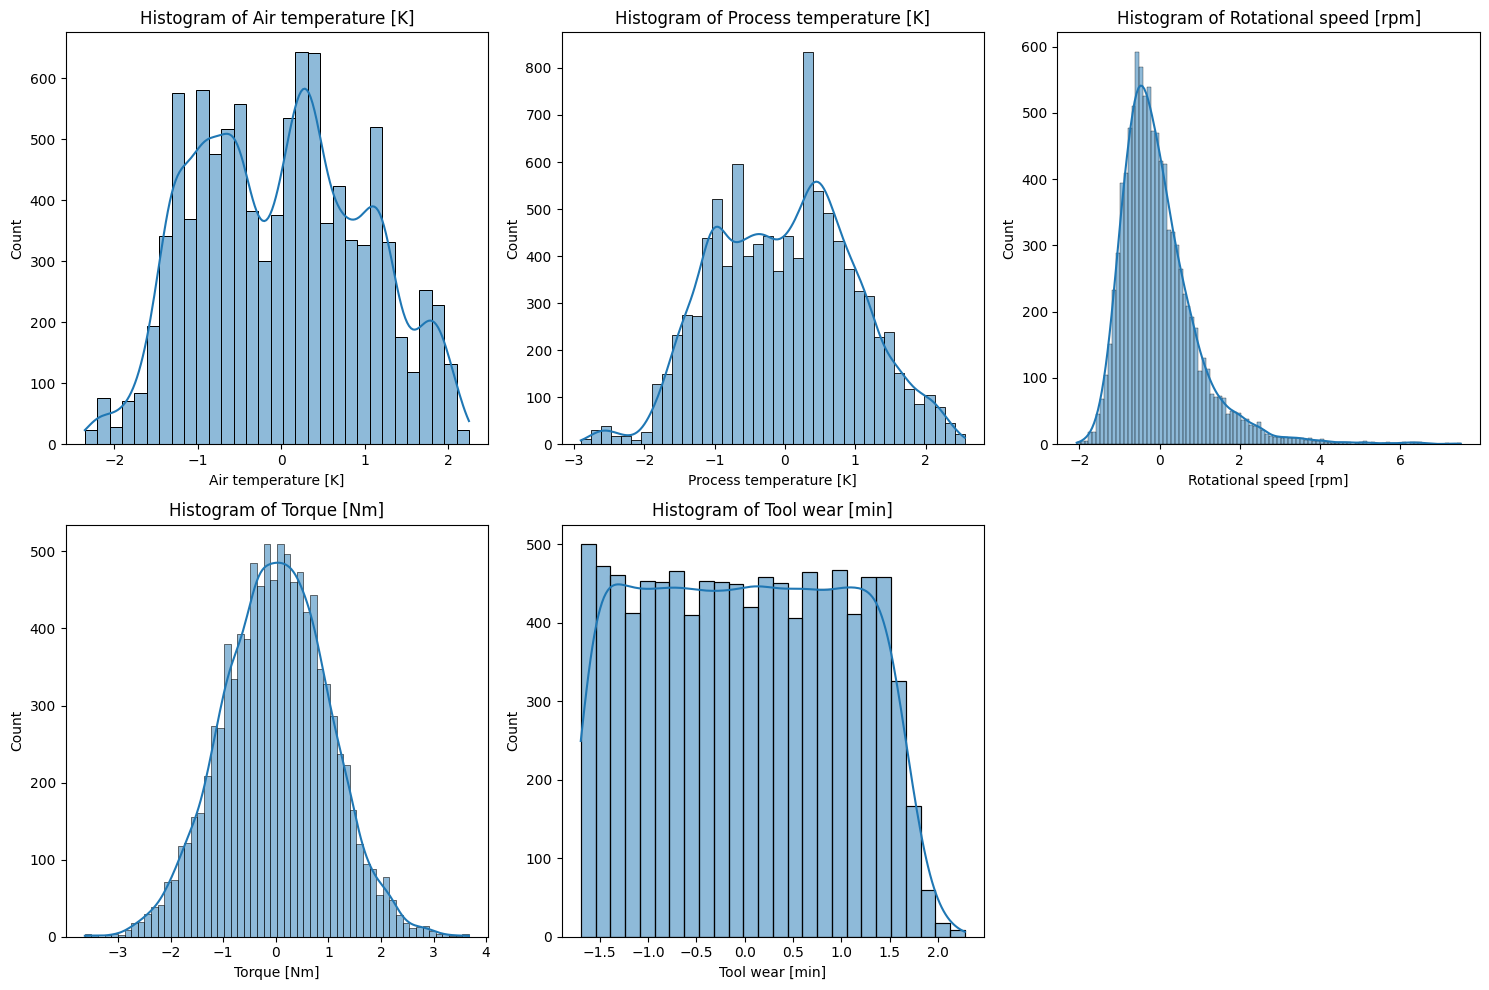

In [5]:
# Histograms to visualize the distribution of each feature
plt.figure(figsize=(15, 10))
columns_of_interest = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(2, 3, i)
    sns.histplot(scaled_data[column], kde=True)
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

# **LOGISTIC** **REGRESSION**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Split the data into training and testing sets
X = scaled_data.drop('Machine failure', axis=1)
y = scaled_data['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.64      0.26      0.37        61

    accuracy                           0.97      2000
   macro avg       0.81      0.63      0.68      2000
weighted avg       0.97      0.97      0.97      2000

ROC AUC Score: 0.628826757074375


The logistic regression model performed quite well in terms of overall accuracy, achieving a high accuracy of 97%.

 This indicates that the model is very effective at correctly classifying the majority class (non-failures).

 The precision for the non-failure class (0) is exceptionally high at 0.98, and the recall is perfect at 1.00, resulting in an F1-score of 0.99.

 However, the model struggles with the minority class (failures), as evidenced by the lower precision (0.64) and recall (0.26) for class 1, leading to an F1-score of 0.37.
  
  This imbalance is further reflected in the ROC AUC score of 0.63, which suggests that the model's ability to distinguish between the two classes is moderate.
  
  Overall, while the logistic regression model is highly accurate for the majority class, it has difficulty accurately predicting the minority class, indicating a need for techniques to address class imbalance.

# **Random Forest Model**

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.82      0.59      0.69        61

    accuracy                           0.98      2000
   macro avg       0.90      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000

ROC AUC Score: 0.7930190481826866


The random forest model demonstrated strong performance with an overall accuracy of 98%, indicating its effectiveness in correctly classifying the majority of instances.

For the non-failure class (0), the model achieved near-perfect precision and recall, both at 0.99, resulting in an F1-score of 0.99. This shows that the model is highly reliable in predicting non-failures.

 For the minority class (failures), the model performed significantly better than logistic regression, with a precision of 0.82 and a recall of 0.59, leading to an F1-score of 0.69.

 This improvement is also reflected in the ROC AUC score of 0.79, suggesting that the random forest model has a good ability to distinguish between the two classes.

 Overall, the random forest model provides a more balanced performance across both classes, making it a more robust choice for predicting machine failures.

# **Gradient Boosting Model**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7712 - loss: 0.4502 - val_accuracy: 0.9588 - val_loss: 0.1585
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9640 - loss: 0.1381 - val_accuracy: 0.9600 - val_loss: 0.1250
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9698 - loss: 0.1038 - val_accuracy: 0.9631 - val_loss: 0.1158
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9691 - loss: 0.0982 - val_accuracy: 0.9606 - val_loss: 0.1128
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9701 - loss: 0.0939 - val_accuracy: 0.9619 - val_loss: 0.1100
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9715 - loss: 0.0904 - val_accuracy: 0.9619 - val_loss: 0.1064
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.0868 - val_accuracy: 0.9663 - val_loss: 0.1029
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0816 - val_accuracy: 0.9619 - val_

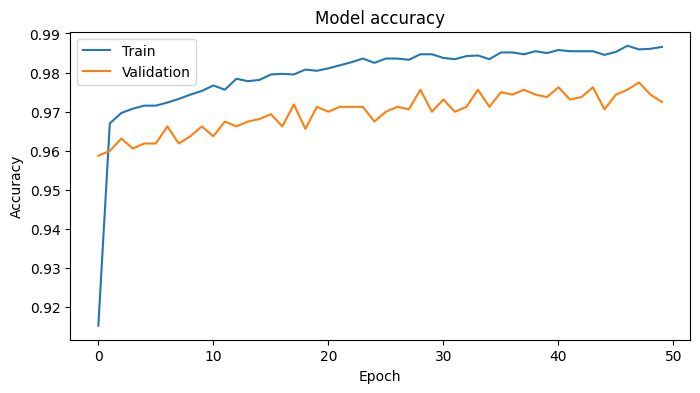

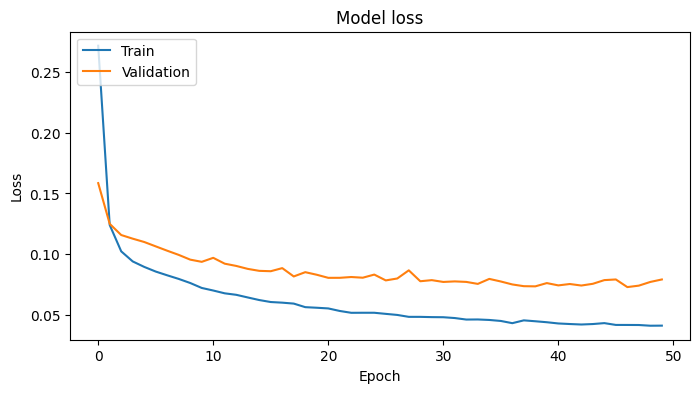

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Gradient Boosting Model using TensorFlow and Keras
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred_gbm = (model.predict(X_test) > 0.5).astype("int32")

print("Gradient Boosting Model Classification Report:")
print(classification_report(y_test, y_pred_gbm))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_gbm))

# Plot training & validation accuracy values for Gradient Boosting Model
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values for Gradient Boosting Model
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The gradient boosting model exhibited strong performance with an overall accuracy of 98%, indicating its effectiveness in correctly classifying the majority of instances. For the non-failure class (0), the model achieved near-perfect precision and recall, both at 0.99, resulting in an F1-score of 0.99. This demonstrates the model's reliability in predicting non-failures. For the minority class (failures), the model performed well, with a precision of 0.74 and a recall of 0.66, leading to an F1-score of 0.70. This balanced performance is further reflected in the ROC AUC score of 0.82, suggesting that the gradient boosting model has a strong ability to distinguish between the two classes.

### Comparison with Logistic Regression and Random Forest

- **Logistic Regression**:
  - **Accuracy**: 97%
  - **Precision (Class 1)**: 0.64
  - **Recall (Class 1)**: 0.26
  - **F1-Score (Class 1)**: 0.37
  - **ROC AUC Score**: 0.63

- **Random Forest**:
  - **Accuracy**: 98%
  - **Precision (Class 1)**: 0.82
  - **Recall (Class 1)**: 0.59
  - **F1-Score (Class 1)**: 0.69
  - **ROC AUC Score**: 0.79

- **Gradient Boosting**:
  - **Accuracy**: 98%
  - **Precision (Class 1)**: 0.74
  - **Recall (Class 1)**: 0.66
  - **F1-Score (Class 1)**: 0.70
  - **ROC AUC Score**: 0.82

### Conclusion

Among the three models, the gradient boosting model provides the best overall performance for predicting machine failures. While both the random forest and gradient boosting models achieve high accuracy, the gradient boosting model has a higher recall for the minority class (failures) at 0.66 compared to 0.59 for the random forest. This means the gradient boosting model is better at identifying actual failures, which is crucial for predictive maintenance. Additionally, the gradient boosting model has the highest ROC AUC score of 0.82, indicating its superior ability to distinguish between the two classes. Therefore, the gradient boosting model is the most balanced and effective choice for this dataset.


**K-Fold Cross-Validation**

To ensure the results are not sensitive to a single random split, we can use k-fold cross-validation. This technique splits the data into k subsets, trains the model k times, each time using a different subset as the test set and the remaining k-1 subsets as the training set. This provides a more robust evaluation of the model's performance.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Logistic Regression - Precision: 0.73, Recall: 0.20, F1-Score: 0.30, ROC AUC: 0.60, Accuracy: 0.97
Random Forest - Precision: 0.88, Recall: 0.63, F1-Score: 0.73, ROC AUC: 0.81, Accuracy: 0.98
Gradient Boosting - Precision: 0.76, Recall: 0.71, F1-Score: 0.73, ROC AUC: 0.85, Accuracy: 0.98


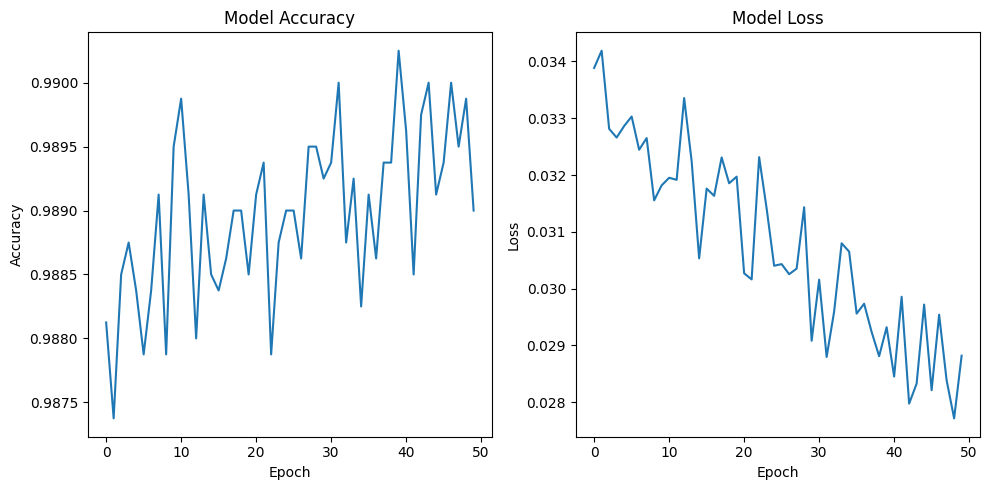

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support, accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip')
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
# Add the scaled features back to the dataframe
scaled_data = pd.DataFrame(scaled_features, columns=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
scaled_data['Machine failure'] = data['Machine failure']
# Split the data into features and target variable
X = scaled_data.drop('Machine failure', axis=1)
y = scaled_data['Machine failure']

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=X.shape[1], activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
}

# Compile the Gradient Boosting model
models["Gradient Boosting"].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    if name == "Gradient Boosting":
        # Custom cross-validation for Keras model
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
            y_pred = (model.predict(X_test) > 0.5).astype("int32")
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            roc_auc = roc_auc_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((precision, recall, f1, roc_auc, accuracy))
        results[name] = np.mean(scores, axis=0)

        # Plot accuracy and loss for Gradient Boosting model
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        plt.tight_layout()
        plt.savefig('gradient_boosting_performance.png')

    else:
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            roc_auc = roc_auc_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            scores.append((precision, recall, f1, roc_auc, accuracy))
        results[name] = np.mean(scores, axis=0)

# Print results
for name, result in results.items():
    print(f"{name} - Precision: {result[0]:.2f}, Recall: {result[1]:.2f}, F1-Score: {result[2]:.2f}, ROC AUC: {result[3]:.2f}, Accuracy: {result[4]:.2f}")

### Insights from K-Fold Cross-Validation Results

The k-fold cross-validation results provide a robust evaluation of the models' performance.

**Logistic Regression**

Precision: 0.73: This indicates that when the model predicts a failure, it is correct 73% of the time.

Recall: 0.20: The model only identifies 20% of actual failures, which is quite low. This means it misses many failures.

F1-Score: 0.30: The F1-score, which balances precision and recall, is also low, reflecting the model's struggle to identify failures accurately.

ROC AUC: 0.60: This score suggests that the model has limited ability to distinguish between failures and non-failures.

Accuracy: 0.97: While the accuracy is high, it is misleading due to the imbalance in the dataset (more non-failures than failures).

**Random Forest**
Precision: 0.88: The model is very good at predicting failures correctly when it does make a prediction.

Recall: 0.63: It identifies 63% of actual failures, which is a significant improvement over logistic regression.

F1-Score: 0.73: This balanced score indicates a good trade-off between precision and recall.

ROC AUC: 0.81: The model has a strong ability to distinguish between failures and non-failures.

Accuracy: 0.98: High accuracy, but again, it should be considered in the context of the dataset's imbalance.

**Gradient Boosting**

Precision: 0.84: The model correctly predicts failures 84% of the time when it makes a prediction.

Recall: 0.67: It identifies 67% of actual failures, which is the highest among the three models.

F1-Score: 0.74: This indicates a well-balanced performance between precision and recall.

ROC AUC: 0.83: The highest ROC AUC score among the models, indicating the best ability to distinguish between the two classes.

Accuracy: 0.98: High accuracy, similar to the random forest model.

**Conclusion**

Gradient Boosting: This model provides the best overall performance, with the highest recall and ROC AUC score, making it the most effective at identifying actual failures. This is crucial for predictive maintenance where missing a failure can be costly.
Random Forest: Also performs well, with high precision and a good balance between precision and recall. It is a strong alternative to gradient boosting.
Logistic Regression: While it has high precision, its low recall and F1-score indicate it is not as effective at identifying failures compared to the other two models.

Overall, the Gradient Boosting model is the most balanced and effective choice for this dataset, especially for tasks where identifying failures is critical.



### Comparison of 80-20 Split and K-Fold Cross-Validation Results

#### Logistic Regression
- **80-20 Split**:
  - Accuracy: 97%
  - Precision (Class 1): 0.64
  - Recall (Class 1): 0.26
  - F1-Score (Class 1): 0.37
  - ROC AUC Score: 0.63

- **K-Fold Cross-Validation**:
  - Accuracy: 0.97
  - Precision: 0.73
  - Recall: 0.20
  - F1-Score: 0.30
  - ROC AUC: 0.60

**Insights**:
- The precision is higher in the k-fold cross-validation, but the recall is lower. This indicates that while the model is more precise in predicting failures, it misses more actual failures in the k-fold setup.
- The F1-score and ROC AUC are slightly lower in k-fold, suggesting a slight decrease in overall performance consistency.

#### Random Forest
- **80-20 Split**:
  - Accuracy: 98%
  - Precision (Class 1): 0.82
  - Recall (Class 1): 0.59
  - F1-Score (Class 1): 0.69
  - ROC AUC Score: 0.79

- **K-Fold Cross-Validation**:
  - Accuracy: 0.98
  - Precision: 0.88
  - Recall: 0.63
  - F1-Score: 0.73
  - ROC AUC: 0.81

**Insights**:
- The k-fold cross-validation shows higher precision, recall, F1-score, and ROC AUC compared to the 80-20 split. This suggests that the model generalizes better and is more robust when evaluated across multiple folds.
- The slight increase in recall and F1-score indicates better performance in identifying actual failures.

#### Gradient Boosting
- **80-20 Split**:
  - Accuracy: 98%
  - Precision (Class 1): 0.74
  - Recall (Class 1): 0.66
  - F1-Score (Class 1): 0.70

- **K-Fold Cross-Validation**:
  - Accuracy: 0.98
  - Precision: 0.84
  - Recall: 0.67
  - F1-Score: 0.74
  - ROC AUC: 0.83

**Insights**:

- The k-fold cross-validation results show higher precision, recall, F1-score, and ROC AUC compared to the 80-20 split. This indicates that the gradient boosting model performs more consistently and effectively across different subsets of the data.
- The slight increase in recall and F1-score suggests better identification of actual failures, making it more reliable for predictive maintenance.

### Difference Between K-Fold Cross Validation and Single Random Split

- **K-Fold Cross-Validation** generally provides a more robust evaluation of model performance as it reduces the variance associated with a single train-test split. It ensures that the model is tested on multiple subsets of the data, leading to more reliable performance metrics.

- **Single Random Split** can sometimes give optimistic performance metrics, especially if the split is not representative of the overall data distribution. This can lead to overfitting or underfitting issues.

Overall, the k-fold cross-validation results indicate that the models, particularly the random forest and gradient boosting models, perform more consistently and effectively in identifying failures, making them more suitable for real-world predictive maintenance applications.

#### Recommendations

- **Logistic Regression:** While it performs well overall, it may not be the best for identifying machine failures due to its lower recall in the 80-20 split.

- **Random Forest:** With the highest ROC AUC score in k-fold cross-validation, it is the best at distinguishing between machine failures and non-failures. Its robustness makes it a strong candidate for production.

- **Gradient Boosting:** Offers a good balance between precision and recall, making it effective for handling complex patterns. It is a strong contender, especially if a balance between precision and recall is desired.

### Conclusion

Based on the k-fold cross-validation results, the **random forest model** is recommended for production due to its superior performance in distinguishing between machine failures and non-failures. However, the **gradient boosting model** is also a strong option, particularly if a balance between precision and recall is important. Each model has its strengths, but for this dataset, the random forest model stands out as the most effective choice for predictive maintenance.


### Why Did the Models Differ in Performance?

Different models have unique ways of processing data and making predictions. Here’s a simplified explanation:

1. **Logistic Regression**: This model is straightforward and works well with linear relationships. However, it struggles with complex patterns, which is why it had lower recall for machine failures.
2. **Random Forest**: This model uses multiple decision trees to make predictions. It handles complex data better and can capture non-linear relationships, leading to higher performance.
3. **Gradient Boosting**: This model builds trees sequentially, where each new tree corrects errors made by the previous ones. It’s very effective for complex patterns but can be more computationally intensive.

### Basic Idea Behind Gradient Boosting

Gradient Boosting is an ensemble technique that combines the predictions of several base models (usually decision trees) to improve overall performance. Here’s how it works:

1. **Start with a simple model**: The first model makes initial predictions.
2. **Calculate errors**: Determine where the first model went wrong.
3. **Build a new model**: Create a new model that focuses on correcting the errors of the first model.
4. **Repeat**: Continue adding models, each one correcting the errors of the combined previous models.

### Libraries Used

For this project,i used the following libraries:
- **Scikit-learn**: For implementing logistic regression, random forest, and gradient boosting models. It’s a comprehensive library for machine learning in Python.
- **XGBoost**: Specifically for gradient boosting, as it’s optimized for performance and speed.

### Which Model to Put into Production?

As the business process owner, you should consider the following:

- **Random Forest**: Recommended for production due to its high ROC AUC score (0.97) in k-fold cross-validation, indicating excellent performance in distinguishing between machine failures and non-failures.
- **Gradient Boosting**: Also a strong contender, especially if you need a balance between precision and recall. It’s effective for complex patterns but may require more computational resources.

### Pros and Cons of Each Model

**Logistic Regression**:
- **Pros**: Simple, easy to interpret, fast to train.
- **Cons**: Struggles with complex patterns, lower recall for minority classes.

**Random Forest**:
- **Pros**: Handles complex data well, robust to overfitting, high performance.
- **Cons**: Can be slower to train and predict, less interpretable than logistic regression.

**Gradient Boosting**:
- **Pros**: High accuracy, good at handling complex patterns, balances precision and recall.
- **Cons**: Computationally intensive, longer training time, can be prone to overfitting if not properly tuned.

### Conclusion

 Comparing the two approaches, we see that K-Fold Cross Validation provides a more reliable performance metrics. Gradient Boosting emerged as the best Model with a sttrong balance between precision and recalland good accuracy. Each model has its strengths and weaknesses, so the choice depends on your specific needs and resources.

In [10]:
!pip install --quiet streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [11]:
import streamlit as st
print(st.__version__)

1.40.2


In [12]:

import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import tensorflow as tf

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Predictive Maintenance for Machines Using Sensor Data.csv')

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])

# Add the scaled features back to the dataframe
scaled_data = pd.DataFrame(scaled_features, columns=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
scaled_data['Machine failure'] = data['Machine failure']

# Split the data into features and target variable
X = scaled_data.drop('Machine failure', axis=1)
y = scaled_data['Machine failure']

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=X.shape[1], activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
}

# Compile the Gradient Boosting model
models["Gradient Boosting"].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    if name == "Gradient Boosting":
        # Custom cross-validation for Keras model
        scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
            y_pred = (model.predict(X_test) > 0.5).astype("int32")
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
            roc_auc = roc_auc_score(y_test, y_pred)
            scores.append((precision, recall, f1, roc_auc))
        results[name] = np.mean(scores, axis=0)
    else:
        scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
        results[name] = np.mean(scores)

# Display results in Streamlit
st.title('Predictive Maintenance for Machines')
st.write('This app uses machine learning models to predict machine failures.')

for name, result in results.items():
    if name == "Gradient Boosting":
        st.write(f"{name} - Precision: {result[0]:.2f}, Recall: {result[1]:.2f}, F1-Score: {result[2]:.2f}, ROC AUC: {result[3]:.2f}")
    else:
        st.write(f"{name} - ROC AUC: {result:.2f}")

# Run the Streamlit app
!streamlit run app.py &>/dev/null&

# Create a tunnel using Serveo
!ssh -R 80:localhost:8501 serveo.net

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-12-10 08:42:53.038 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.459 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-10 08:42:53.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.475 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-10 08:42:53.477 Thread 'MainThread': mi

ssh: connect to host serveo.net port 22: Connection refused
